source: https://www.kaggle.com/gauravduttakiit/explore-the-poisson-regression/notebook

In [ ]:
pip install pyro-ppl-1.8.0

     |████████████████████████████████| 718 kB 4.1 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 6]

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/seanreed1111/datasets/master/count-regression-datasets/competition_awards_data.csv")
df.columns = ['award_count', 'math_score']
df.head()

,award_count,math_score
0,0,43
1,0,38
2,0,41
3,0,33
4,0,39


In [ ]:
df.describe()

,award_count,math_score
count,200.000000,200.000000
mean,0.630000,50.715000
std,1.052921,19.148029
min,0.000000,30.000000
25%,0.000000,35.000000
50%,0.000000,42.000000
75%,1.000000,66.000000
max,6.000000,91.000000


In [ ]:
X = df.copy()

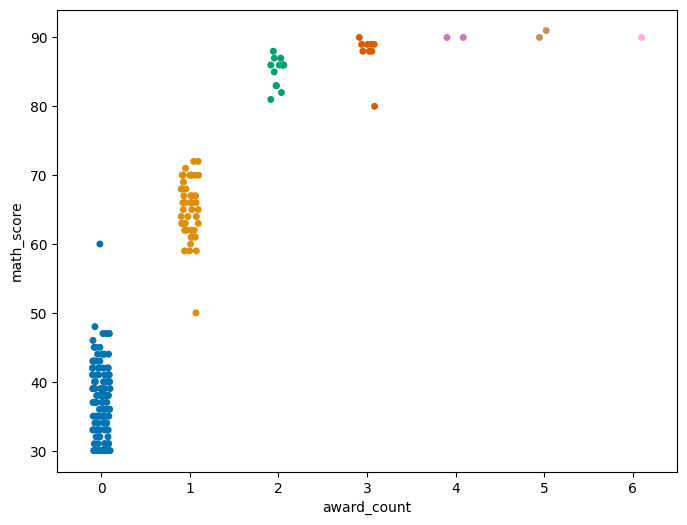

In [ ]:
sns.stripplot(data=X, x='award_count', y='math_score', palette='colorblind');

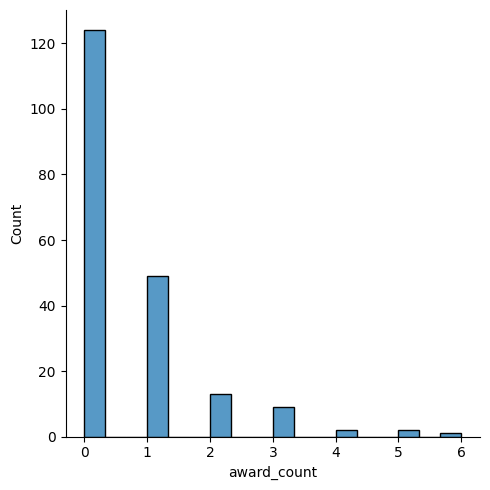

In [ ]:
sns.displot(data=X, x='award_count', palette='colorblind');

Poisson Distribution should have equal mean and variance. Let's check:

In [ ]:
X['award_count'].mean(), X['award_count'].var() # Variance larger than the mean. Overdispersed.

(0.63, 1.108643216080402)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


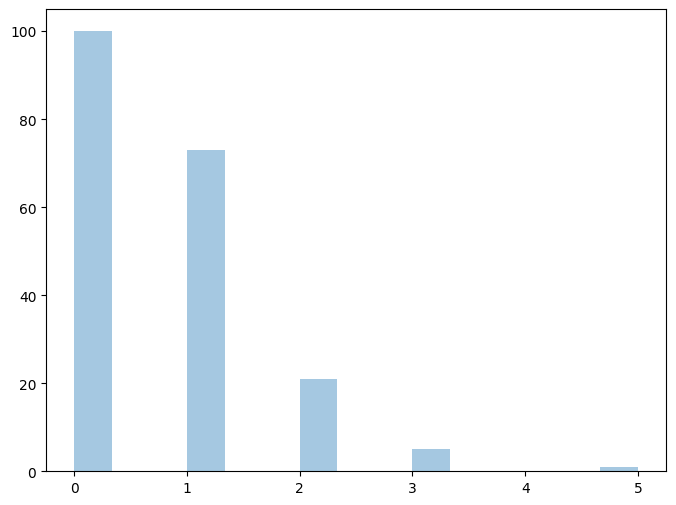

In [ ]:
samples_1 = dist.Poisson(X['award_count'].mean()).sample(tensor([200])) # create sample distribution where Poisson mean = data mean
sns.distplot(samples_1.numpy(), kde=False);

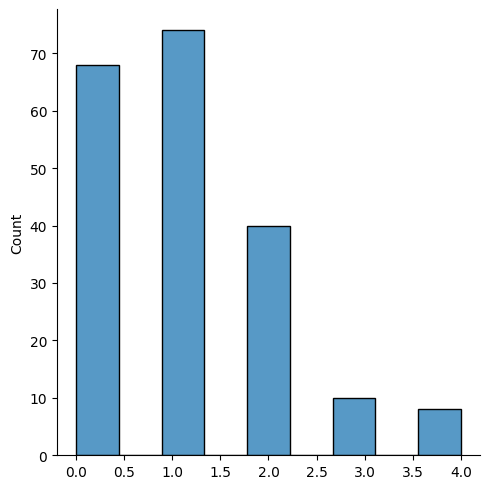

In [ ]:
samples_2 = dist.Poisson(X['award_count'].var()).sample(tensor([200])) # create sample distribution where Poisson mean = data variance
sns.displot(samples_2.numpy());

### So, comparing the actual data with the above two poisson sampling distributions above, it appears our data is both zero inflated AND overdispersed!

let's make a Poisson model with 'award_count ~ math_score' 

In [ ]:
data = X[['math_score']]
target = X['award_count']

## Using sklearn

In [ ]:
data.shape, target.shape

((200, 1), (200,))

In [ ]:
from sklearn.linear_model import PoissonRegressor #Generalized Linear Model with a Poisson distribution and log link.

reg = PoissonRegressor().fit(data.values, target.values)

In [ ]:
# these are MLE estimates of parameters we expect to recover
print(reg.intercept_)
print(reg.coef_)

-5.465562509571889
[0.0759304]


In [ ]:
reg.score(data.values.reshape(-1,1), target)

0.861564879362117

## Using statsmodels

In [ ]:
import statsmodels.formula.api as smf
statsmod = smf.poisson(formula='award_count ~ math_score', data=X)
result = statsmod.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.539676
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:            award_count   No. Observations:                  200
Model:                        Poisson   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Apr 2022   Pseudo R-squ.:                  0.5345
Time:                        01:19:01   Log-Likelihood:                -107.94
converged:                       True   LL-Null:                       -231.86
Covariance Type:            nonrobust   LLR p-value:                 7.616e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5094      0.487    -11.319      0.000      -6.463      -4.555
math_score     0.0765      0.

## Using Bayesian Regression with SVI

In [ ]:
# convert data and target to torch tensors
data = tensor(data.values, dtype=torch.float)
target = tensor(target.values, dtype=torch.float)

In [ ]:
data.size(), target.size()

(torch.Size([200, 1]), torch.Size([200]))

In [ ]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

# need to pass the priors for all models as parameters to the object.
class BayesianPoissonRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        if bias:
          self.linear.bias = PyroSample(dist.Normal(0., 5.).expand([out_features]).to_event(1))
        self.linear.weight = PyroSample(dist.Normal(0., 0.05).expand([out_features, in_features]).to_event(2))

        
    def forward(self, x, y=None):
        rate = self.linear(x).squeeze(-1).exp() #we are using log link, so apply inverse of log to the matrix multiplication, i.e. exp
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Poisson(rate), obs=y)
        return rate

In [ ]:
model = BayesianPoissonRegression(data.size(1)) 

In [ ]:
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [ ]:
def train(model, guide, lr=0.01, n_steps=4000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")
    print(f"Final Elbo loss: {elbo}")

In [ ]:
%%time
train(model, guide)

Elbo loss: 13700.007315039635
Elbo loss: 192.13812470436096
Elbo loss: 154.6260551214218
Elbo loss: 124.89329898357391
Elbo loss: 115.784552693367
Elbo loss: 124.62245285511017
Elbo loss: 131.13484585285187
Elbo loss: 133.94092786312103
Final Elbo loss: 127.22214925289154
CPU times: user 16.6 s, sys: 21.5 ms, total: 16.6 s
Wall time: 16.7 s


In [ ]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

In [ ]:
svi_samples.keys()

dict_keys(['linear.weight', 'linear.bias'])

In [ ]:
svi_samples['linear.bias'].mean()

-3.5885293

In [ ]:
svi_samples['linear.weight'].mean(axis=0)

array([0.05182689], dtype=float32)

In [ ]:
guide.quantiles([0.05,0.50,0.95])

{'linear.bias': tensor([[-3.8828],
         [-3.5804],
         [-3.2780]]), 'linear.weight': tensor([[[0.0413]],
 
         [[0.0519]],
 
         [[0.0625]]])}

In [ ]:
print(reg.intercept_)
print(reg.coef_)

-5.465562509571889
[0.0759304]


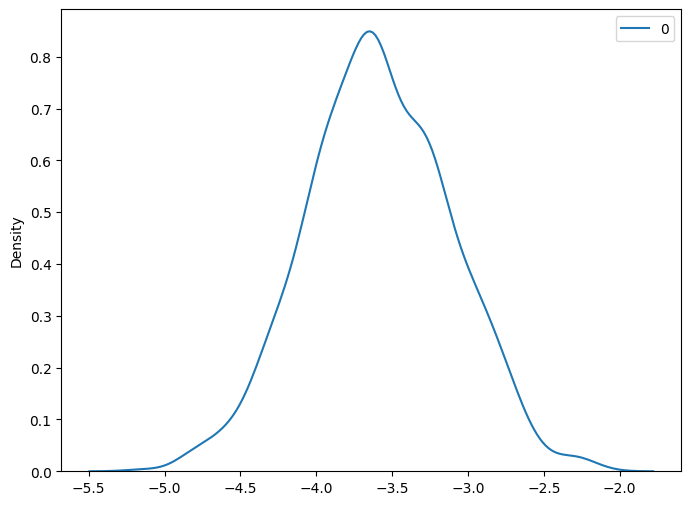

In [ ]:
sns.kdeplot(data = svi_samples['linear.bias']);

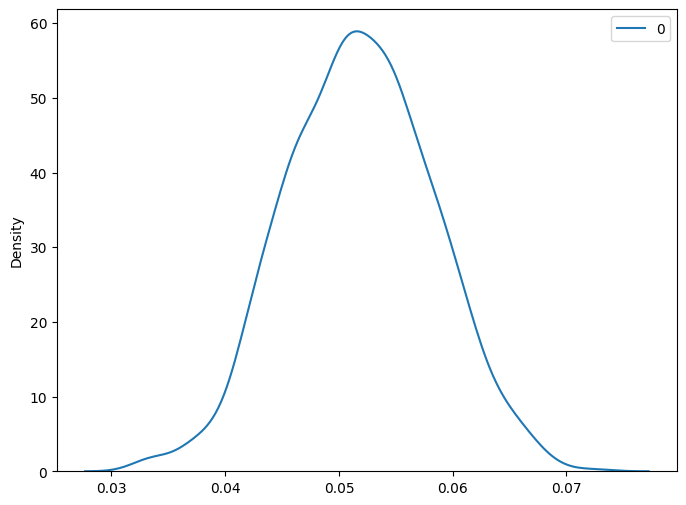

In [ ]:
sns.kdeplot(data = svi_samples['linear.weight']);

In [ ]:
# So all three methods seem to be in agreement about the central tendencies of the coefficients.

# What about MCMC?

In [ ]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=800, warmup_steps=500)

In [ ]:
%%time
mcmc.run(data, target)

Sample: 100%|██████████| 1300/1300 [01:07, 19.30it/s, step size=1.05e-01, acc. prob=0.949]

CPU times: user 1min 2s, sys: 443 ms, total: 1min 2s
Wall time: 1min 7s


In [ ]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [ ]:
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight'])

In [ ]:
np.median(hmc_samples['linear.bias'])

-5.3776665

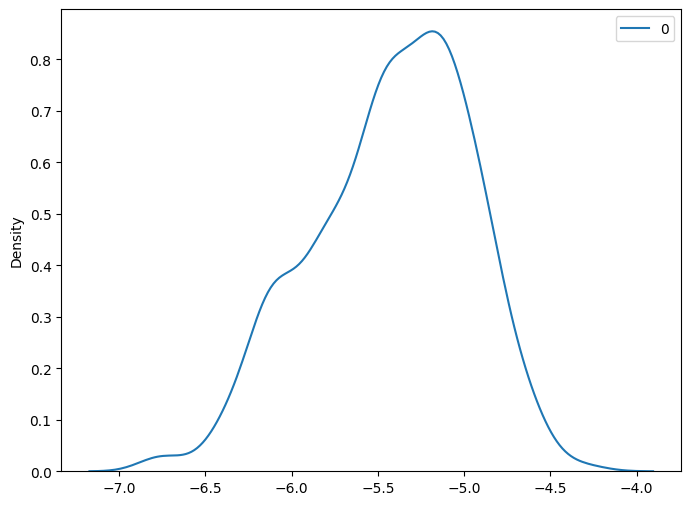

In [ ]:
sns.kdeplot(data=hmc_samples['linear.bias']);

In [ ]:
hmc_samples['linear.weight'].shape

(800, 1, 1)

0.074806586


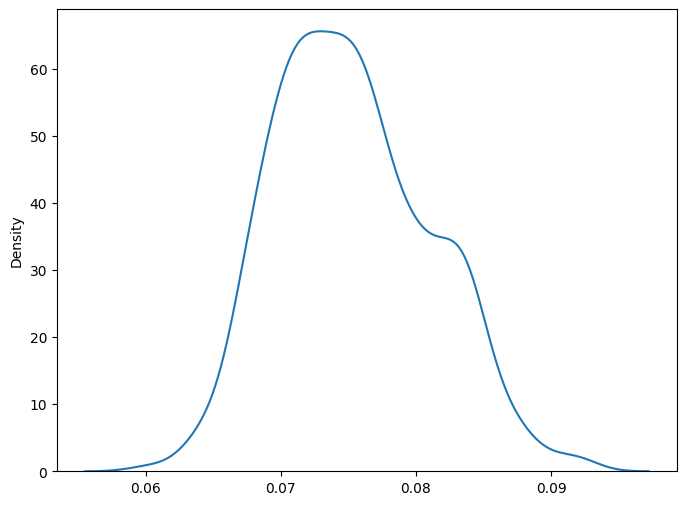

In [ ]:
print(np.median(hmc_samples['linear.weight'][:,0,0]))
sns.kdeplot(data=hmc_samples['linear.weight'][:,0,0]);

0.074806586


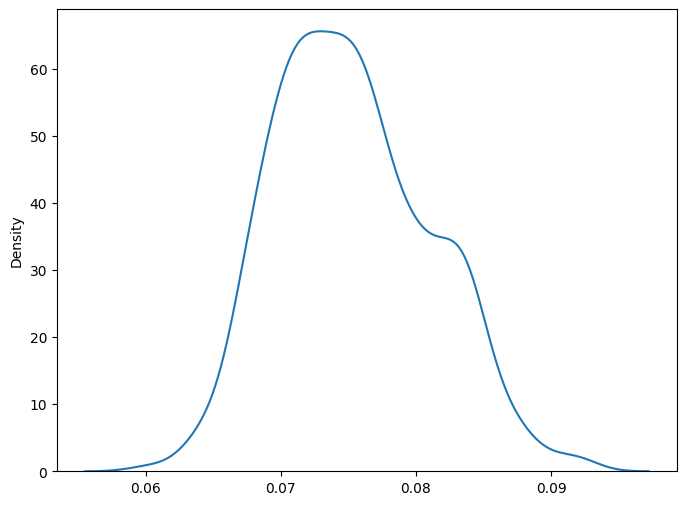

In [ ]:
print(np.median(hmc_samples['linear.weight'][:,0,0]))
sns.kdeplot(data=hmc_samples['linear.weight'][:,0,0]);

In [ ]:
# sklearn estimate
print(reg.intercept_)
print(reg.coef_)


-5.465562509571889
[0.0759304]


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


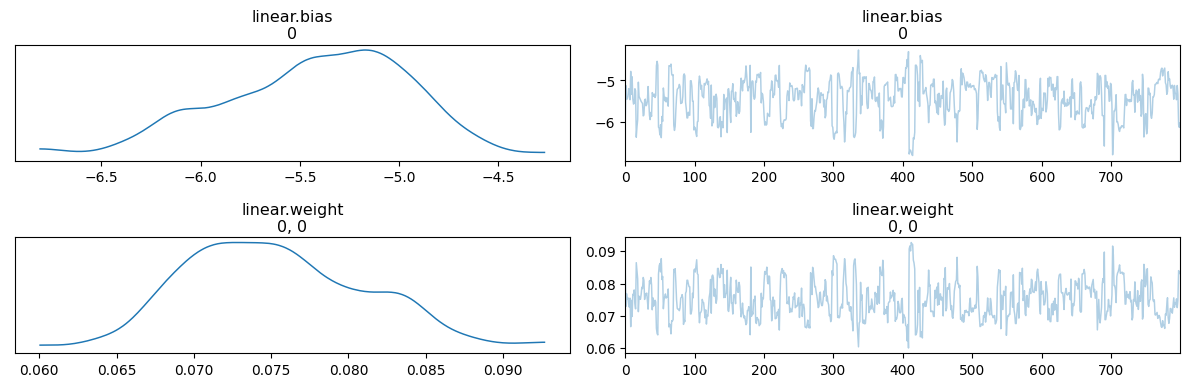

In [ ]:
import arviz as az

az_data = az.from_pyro(mcmc)
az.plot_trace(az_data, compact=False)
plt.tight_layout()